# Предсказание цен на недвижимость

Данные - https://www.kaggle.com/c/sberbank-russian-housing-market/data
В датасете представлена информация об объектах недвижимости в г. Москва.
Задания:
- Построить модель предсказания цены (price_doc), метрика RMSLE
- Выбрать наименьшее возможное количество признаков, при котором
качество модели будет сопоставимо с моделью с полным набором признаков
- Создать веб-приложение(на Dash или Streamlit), которое при указании параметров предсказывает цену квартиры
- Добавить возможно подбора расположения квартиры по указанной цене
- Создать интерактивную карту (на Dash), на которой можно выбрать место, указать параметры и получить предсказанную цену

In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


In [34]:
def RMSLE(y_true: np.array, y_pred: np.array) -> np.float64:
    return mean_squared_log_error(y_true, y_pred) ** 0.5

Загрузим данные

In [35]:
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('macro.csv')

In [36]:
train.head(1)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 67.9+ MB


In [38]:
def clear (train: pd.DataFrame):

    # Чистка данных
    bad_index = train[train.life_sq > train.full_sq].index
    train.loc[bad_index, "life_sq"] = np.NaN
    bad_index = test[test.life_sq > test.full_sq].index
    test.loc[bad_index, "life_sq"] = np.NaN

    bad_index = train[train.life_sq < 5].index
    train.loc[bad_index, "life_sq"] = np.NaN
    bad_index = test[test.life_sq < 5].index
    test.loc[bad_index, "life_sq"] = np.NaN
    bad_index = train[train.full_sq < 5].index
    train.loc[bad_index, "full_sq"] = np.NaN
    bad_index = test[test.full_sq < 5].index
    test.loc[bad_index, "full_sq"] = np.NaN

    kitch_is_build_year = [13117]
    train.loc[kitch_is_build_year, "build_year"] = train.loc[kitch_is_build_year, "kitch_sq"]

    bad_index = train[train.kitch_sq >= train.life_sq].index
    train.loc[bad_index, "kitch_sq"] = np.NaN
    bad_index = test[test.kitch_sq >= test.life_sq].index
    test.loc[bad_index, "kitch_sq"] = np.NaN

    bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
    train.loc[bad_index, "kitch_sq"] = np.NaN
    bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
    test.loc[bad_index, "kitch_sq"] = np.NaN

    bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
    train.loc[bad_index, "full_sq"] = np.NaN
    bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
    test.loc[bad_index, "full_sq"] = np.NaN

    bad_index = train[train.build_year < 1900].index
    train.loc[bad_index, "build_year"] = np.NaN
    bad_index = test[test.build_year < 1900].index
    test.loc[bad_index, "build_year"] = np.NaN

    bad_index = train[train.build_year > 2018].index
    train.loc[bad_index, "build_year"] = np.NaN
    bad_index = test[test.build_year > 2018].index
    test.loc[bad_index, "build_year"] = np.NaN

    bad_index = train[train.num_room == 0].index
    train.loc[bad_index, "num_room"] = np.NaN
    bad_index = test[test.num_room == 0].index
    test.loc[bad_index, "num_room"] = np.NaN

    bad_index = train[train.floor == 0].index
    train.loc[bad_index, "floor"] = np.NaN
    bad_index = train[train.max_floor == 0].index
    train.loc[bad_index, "max_floor"] = np.NaN
    bad_index = test[test.max_floor == 0].index
    test.loc[bad_index, "max_floor"] = np.NaN

    bad_index = train[train.floor > train.max_floor].index
    train.loc[bad_index, "max_floor"] = np.NaN
    bad_index = test[test.floor > test.max_floor].index
    test.loc[bad_index, "max_floor"] = np.NaN




    train = train.drop(columns=["id", 'timestamp'])
    # Тип object переведем в category
    train.loc[:, train.dtypes == 'object'] =\
        train.select_dtypes(['object'])\
            .apply(lambda x: x.astype('category'))
    train.info()
    #Выделим таргет price_doc
    y = train["price_doc"]
    X = train.drop(columns=["price_doc"])

    #Найдем числовые и категориальные фичи
    num_data = X.select_dtypes([np.number])
    num_features = num_data.columns
    cat_data = X.select_dtypes(["category"])
    cat_features = cat_data.columns

    #Разделим выборку на обучающую и проверочную
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




    return X, y, X_train, X_test, y_train, y_test, num_features, cat_features

In [39]:
X, y, X_train, X_test, y_train, y_test, num_features, cat_features = clear(train)

/var/folders/nr/zx8kt9ln7s78q206k1vs1nyw0000gp/T/ipykernel_37975/1148375263.py:68: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, train.dtypes == 'object'] =\


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 290 entries, full_sq to price_doc
dtypes: category(15), float64(120), int64(155)
memory usage: 64.4 MB


In [47]:
def LE (X_train, X_test):
    num_train = len(X_train)
    x_all = pd.concat([X_train, X_test])

    for c in x_all.columns:
        if x_all[c].dtype == 'category':
            lbl = LabelEncoder()
            lbl.fit(list(x_all[c].values))
            x_all[c] = lbl.transform(list(x_all[c].values))

    X_train = x_all[:num_train]
    X_test = x_all[num_train:]
    return X_train, X_test

In [ ]:
X_train, X_test = LE(X_train, X_test)

In [57]:
def training(X_train, X_test, y_train, y_test, num_features, cat_features, num_strategy, cat_strategy):


    num_preprocessor = Pipeline(
        steps=[
            ("num_imputation", SimpleImputer(strategy=num_strategy))
        ]
    )

    cat_preprocessor = Pipeline(
        steps=[
            ("cat_imputation", SimpleImputer(strategy=cat_strategy)),
            #("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("cat", cat_preprocessor, cat_features),
            ("num", num_preprocessor, num_features),
        ]
    )
    xgbr = xgb.XGBRegressor(random_state=42)
    pipe = make_pipeline(preprocessor, xgbr)
    #scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring = "neg_mean_squared_log_error")
    #print("CVS RMSLE = %.4f" % (-scores.mean()**0.5))


    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_pred = abs(y_pred)



    #return y_pred, y_test
    rmsle = RMSLE(y_test, y_pred)
    print("RMSLE = %.4f" % rmsle)
    return pipe, rmsle

In [42]:
p = training(X_train, X_test, y_train, y_test, num_features, cat_features, "mean", "most_frequent")

RMSLE = 0.4712


In [12]:
feature_importance = p[1].feature_importances_
feature_names = p[:-1].get_feature_names_out()

sorted_idx = feature_importance.argsort()
#feature_importance[sorted_idx[-50:]]

Text(0.5, 1.0, 'Feature Importance')

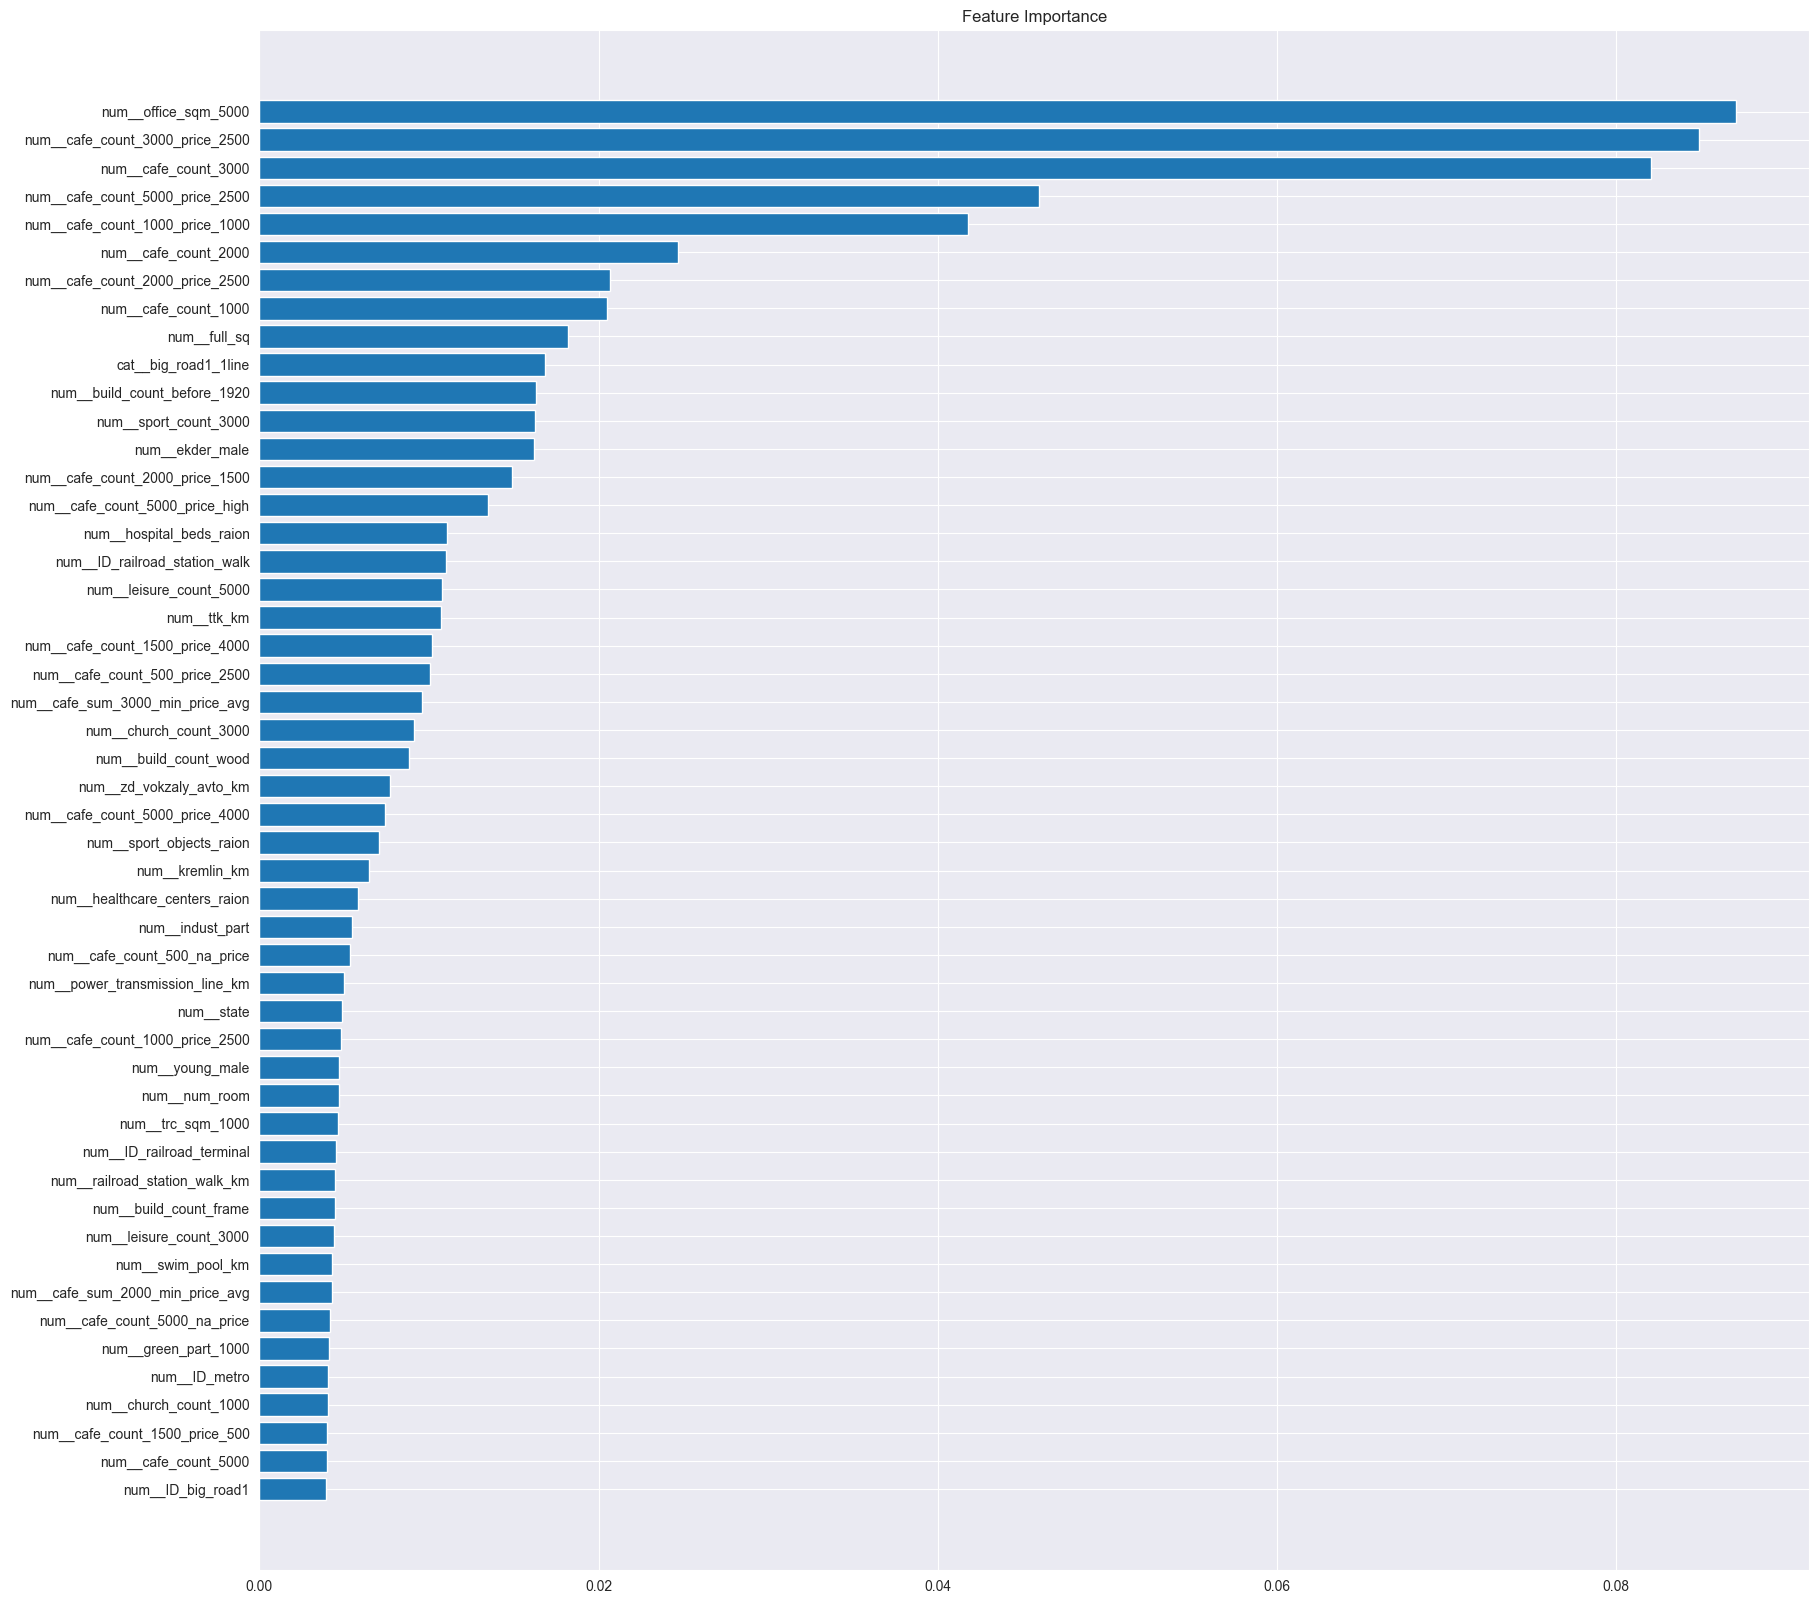

In [13]:
fig = plt.figure(figsize=(20, 20))
plt.barh(feature_names[sorted_idx[-50:]], feature_importance[sorted_idx[-50:]], align='center')
plt.title('Feature Importance')

In [14]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(p, X_test, y_test, n_repeats=30, random_state=42,
                                         #scoring='neg_mean_squared_log_error'
                                         )

Text(0.5, 0, 'Permutation Importance')

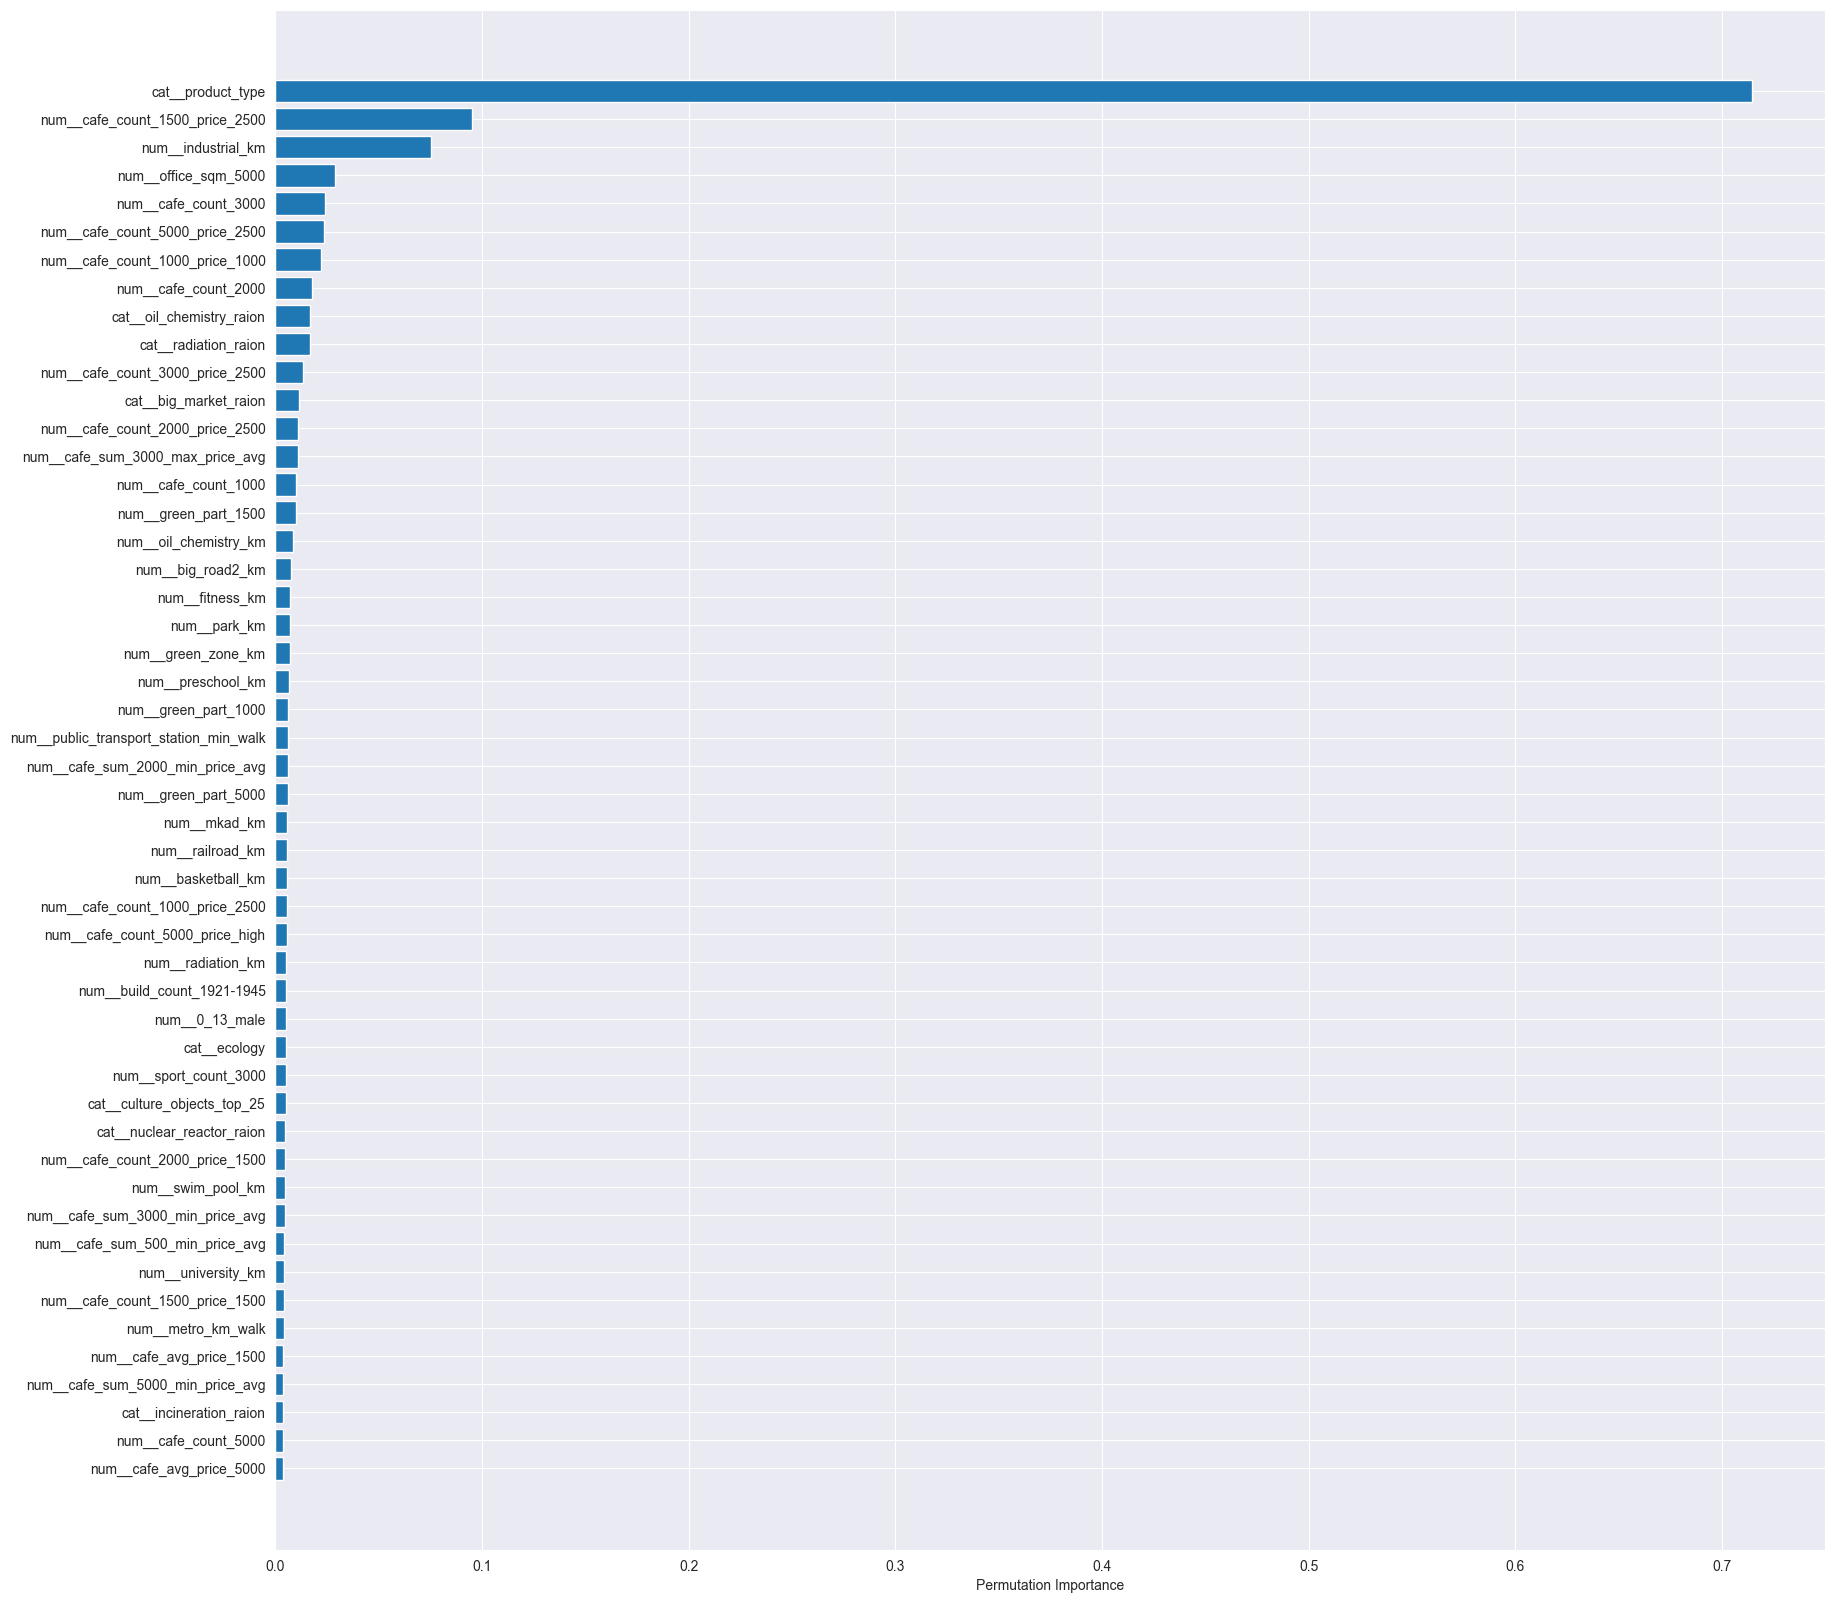

In [15]:
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(20, 20))
plt.barh(feature_names[sorted_idx[-50:]], perm_importance.importances_mean[sorted_idx[-50:]])
plt.xlabel("Permutation Importance")

In [16]:
feature_names[sorted_idx]

array(['num__office_sqm_500', 'num__theater_km',
       'num__cafe_count_500_price_2500', 'num__incineration_km',
       'cat__railroad_terminal_raion', 'num__build_count_block',
       'num__office_count_2000', 'cat__thermal_power_plant_raion',
       'num__trc_sqm_5000', 'num__market_count_3000',
       'num__build_count_1946-1970', 'num__state',
       'num__cafe_sum_1000_max_price_avg',
       'num__cafe_count_1500_price_4000', 'num__life_sq',
       'num__build_year', 'num__build_count_brick',
       'num__cafe_count_1500_na_price', 'num__full_all',
       'num__trc_count_3000', 'num__thermal_power_plant_km',
       'num__young_all', 'num__cafe_count_2000_price_1000',
       'num__raion_build_count_with_builddate_info',
       'num__market_count_5000', 'num__0_13_all', 'num__7_14_all',
       'num__market_count_1000', 'num__market_shop_km',
       'num__school_education_centers_top_20_raion', 'num__0_13_female',
       'num__church_count_2000', 'num__market_count_2000',
       'nu

In [17]:
import re
for i in range(len(feature_names)):
    feature_names[i] = re.search('(?:num__|cat__)(.+)', feature_names[i]).group(1)
    #print(feature_names[i])

In [18]:
feature_names[sorted_idx]

array(['office_sqm_500', 'theater_km', 'cafe_count_500_price_2500',
       'incineration_km', 'railroad_terminal_raion', 'build_count_block',
       'office_count_2000', 'thermal_power_plant_raion', 'trc_sqm_5000',
       'market_count_3000', 'build_count_1946-1970', 'state',
       'cafe_sum_1000_max_price_avg', 'cafe_count_1500_price_4000',
       'life_sq', 'build_year', 'build_count_brick',
       'cafe_count_1500_na_price', 'full_all', 'trc_count_3000',
       'thermal_power_plant_km', 'young_all',
       'cafe_count_2000_price_1000',
       'raion_build_count_with_builddate_info', 'market_count_5000',
       '0_13_all', '7_14_all', 'market_count_1000', 'market_shop_km',
       'school_education_centers_top_20_raion', '0_13_female',
       'church_count_2000', 'market_count_2000', 'cafe_avg_price_3000',
       'public_transport_station_km', 'trc_count_5000',
       'big_church_count_1000', 'big_church_km', 'children_preschool',
       'preschool_education_centers_raion', 'female_f

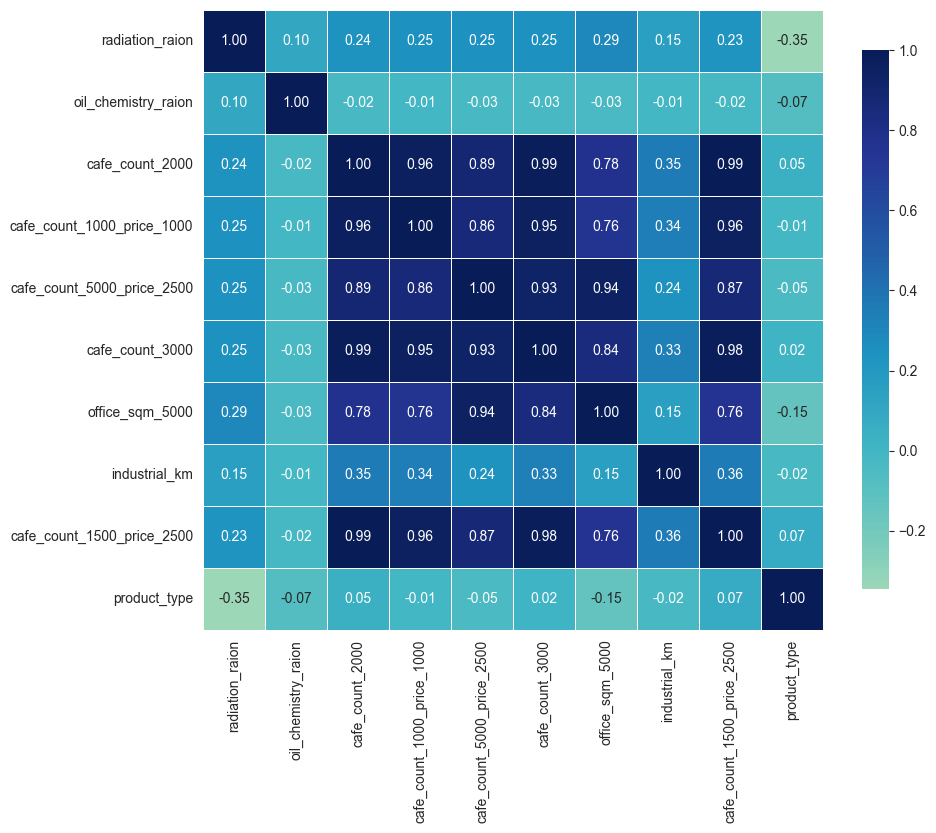

In [19]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();

correlation_heatmap(X_train[feature_names[sorted_idx[-10:]]])

Посчитаем метрику на 50 важных фичах

In [45]:
#Найдем числовые и категориальные фичи
num_data_ = X[feature_names[sorted_idx[-50:]]].select_dtypes([np.number])
num_features_ = num_data_.columns
cat_data_ = X[feature_names[sorted_idx[-50:]]].select_dtypes(["category"])
cat_features_ = cat_data_.columns

#Разделим выборку на обучающую и проверочную
X_train_, X_test_, y_train_, y_test_ = train_test_split(X[feature_names[sorted_idx[-50:]]], y, test_size=0.2, random_state=42)


In [48]:
X_train_, X_test_ = LE(X_train_, X_test_)

In [49]:
p_ = training(X_train_, X_test_, y_train_, y_test_, num_features_, cat_features_, "mean", "most_frequent")

RMSLE = 0.5483


Таким образом при выборе 50 важных фич метрика упала с 0,4712 до 0,5483

Посчитаем метрику на 100 важных фичах

In [50]:
#Найдем числовые и категориальные фичи
num_data_ = X[feature_names[sorted_idx[-100:]]].select_dtypes([np.number])
num_features_ = num_data_.columns
cat_data_ = X[feature_names[sorted_idx[-100:]]].select_dtypes(["category"])
cat_features_ = cat_data_.columns

#Разделим выборку на обучающую и проверочную
X_train_, X_test_, y_train_, y_test_ = train_test_split(X[feature_names[sorted_idx[-100:]]], y, test_size=0.2, random_state=42)


In [51]:
X_train_, X_test_ = LE(X_train_, X_test_)

In [52]:
p_ = training(X_train_, X_test_, y_train_, y_test_, num_features_, cat_features_, "mean", "most_frequent")

RMSLE = 0.5300


Таким образом при выборе 100 важных фич метрика упала с 0,4712 до 0,5300

Посчитаем метрику на 200 важных фичах

In [53]:
#Найдем числовые и категориальные фичи
num_data_ = X[feature_names[sorted_idx[-200:]]].select_dtypes([np.number])
num_features_ = num_data_.columns
cat_data_ = X[feature_names[sorted_idx[-200:]]].select_dtypes(["category"])
cat_features_ = cat_data_.columns

#Разделим выборку на обучающую и проверочную
X_train_, X_test_, y_train_, y_test_ = train_test_split(X[feature_names[sorted_idx[-200:]]], y, test_size=0.2, random_state=42)


In [54]:
X_train_, X_test_ = LE(X_train_, X_test_)

In [55]:
p_ = training(X_train_, X_test_, y_train_, y_test_, num_features_, cat_features_, "mean", "most_frequent")

RMSLE = 0.5041


Таким образом при выборе 200 важных фич метрика упала с 0,4712 до 0,5041

In [74]:
def Test (X,y, n_imp_features):
    #Найдем числовые и категориальные фичи
    num_data_ = X[feature_names[sorted_idx[-n_imp_features:]]].select_dtypes([np.number])
    num_features_ = num_data_.columns
    cat_data_ = X[feature_names[sorted_idx[-n_imp_features:]]].select_dtypes(["category"])
    cat_features_ = cat_data_.columns

    #Разделим выборку на обучающую и проверочную
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X[feature_names[sorted_idx[-n_imp_features:]]], y, test_size=0.2, random_state=42)
    #LabelEncoder
    X_train_, X_test_ = LE(X_train_, X_test_)
    #
    p, rmsle = training(X_train_, X_test_, y_train_, y_test_, num_features_, cat_features_, "mean", "most_frequent")
    return rmsle

In [75]:
Test(X, y, 100)

RMSLE = 0.5300


0.5299902205249437

In [65]:
range(1, len(feature_names),10)

range(0, 289, 10)

In [123]:
rmsle = pd.DataFrame(index=range(1, len(feature_names), 10), columns=['rmsle'])
for i in range(1, len(feature_names), 10):
    rmsle.loc[i,'rmsle'] = Test(X, y, i)

RMSLE = 0.6294
RMSLE = 0.5525
RMSLE = 0.5482
RMSLE = 0.5483
RMSLE = 0.5485
RMSLE = 0.5492
RMSLE = 0.5293
RMSLE = 0.5333
RMSLE = 0.5322
RMSLE = 0.5343
RMSLE = 0.5339
RMSLE = 0.5338
RMSLE = 0.5310
RMSLE = 0.5312
RMSLE = 0.5360
RMSLE = 0.5304
RMSLE = 0.5300
RMSLE = 0.5297
RMSLE = 0.5295
RMSLE = 0.5280
RMSLE = 0.5009
RMSLE = 0.5032
RMSLE = 0.5006
RMSLE = 0.4705
RMSLE = 0.4752
RMSLE = 0.4703
RMSLE = 0.4745
RMSLE = 0.4740
RMSLE = 0.4700


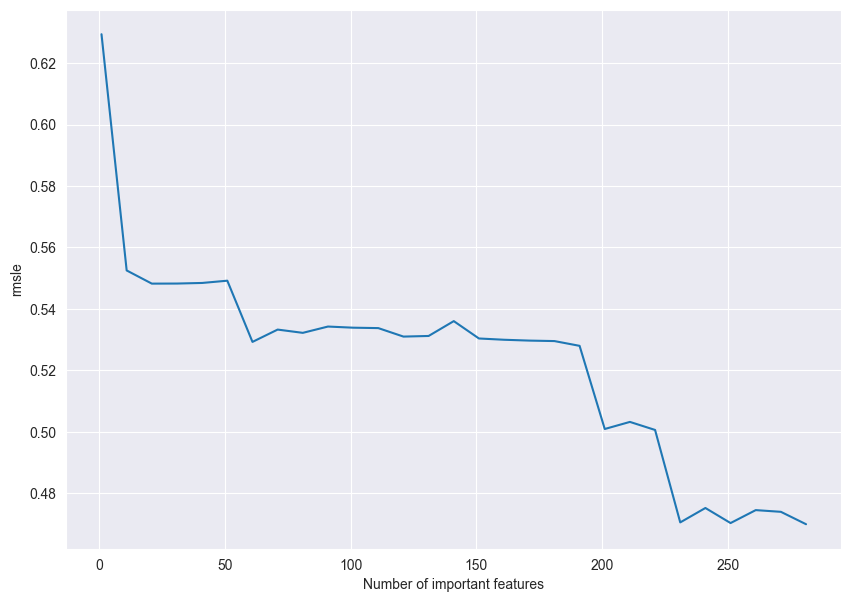

In [126]:

plt.figure(figsize=(10,7))
plt.plot(rmsle)
plt.xlabel('Number of important features')
plt.ylabel('rmsle')
plt.show();

Таким образом, без существенной просадки требуется использовать > 230 фичей